# Building face verification and recognition using FaceNet model

## Loading the FaceNet model

In [1]:
from functools import partial

from keras.models import Model
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import MaxPooling2D
from keras.layers import add
from keras import backend as K


def scaling(x, scale):
    return x * scale


def conv2d_bn(x,
              filters,
              kernel_size,
              strides=1,
              padding='same',
              activation='relu',
              use_bias=False,
              name=None):
    x = Conv2D(filters,
               kernel_size,
               strides=strides,
               padding=padding,
               use_bias=use_bias,
               name=name)(x)
    if not use_bias:
        bn_axis = 1 if K.image_data_format() == 'channels_first' else 3
        bn_name = _generate_layer_name('BatchNorm', prefix=name)
        x = BatchNormalization(axis=bn_axis, momentum=0.995, epsilon=0.001,
                               scale=False, name=bn_name)(x)
    if activation is not None:
        ac_name = _generate_layer_name('Activation', prefix=name)
        x = Activation(activation, name=ac_name)(x)
    return x


def _generate_layer_name(name, branch_idx=None, prefix=None):
    if prefix is None:
        return None
    if branch_idx is None:
        return '_'.join((prefix, name))
    return '_'.join((prefix, 'Branch', str(branch_idx), name))


def _inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
    if block_idx is None:
        prefix = None
    else:
        prefix = '_'.join((block_type, str(block_idx)))
    name_fmt = partial(_generate_layer_name, prefix=prefix)

    if block_type == 'Block35':
        branch_0 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 32, 3, name=name_fmt('Conv2d_0b_3x3', 1))
        branch_2 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_0a_1x1', 2))
        branch_2 = conv2d_bn(branch_2, 32, 3, name=name_fmt('Conv2d_0b_3x3', 2))
        branch_2 = conv2d_bn(branch_2, 32, 3, name=name_fmt('Conv2d_0c_3x3', 2))
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'Block17':
        branch_0 = conv2d_bn(x, 128, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 128, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 128, [1, 7], name=name_fmt('Conv2d_0b_1x7', 1))
        branch_1 = conv2d_bn(branch_1, 128, [7, 1], name=name_fmt('Conv2d_0c_7x1', 1))
        branches = [branch_0, branch_1]
    elif block_type == 'Block8':
        branch_0 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 192, [1, 3], name=name_fmt('Conv2d_0b_1x3', 1))
        branch_1 = conv2d_bn(branch_1, 192, [3, 1], name=name_fmt('Conv2d_0c_3x1', 1))
        branches = [branch_0, branch_1]
    else:
        raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "Block35", "Block17" or "Block8", '
                         'but got: ' + str(block_type))

    mixed = Concatenate(axis=channel_axis, name=name_fmt('Concatenate'))(branches)
    up = conv2d_bn(mixed,
                   K.int_shape(x)[channel_axis],
                   1,
                   activation=None,
                   use_bias=True,
                   name=name_fmt('Conv2d_1x1'))
    up = Lambda(scaling,
                output_shape=K.int_shape(up)[1:],
                arguments={'scale': scale})(up)
    x = add([x, up])
    if activation is not None:
        x = Activation(activation, name=name_fmt('Activation'))(x)
    return x


def InceptionResNetV1(input_shape=(160, 160, 3),
                      classes=128,
                      dropout_keep_prob=0.8,
                      weights_path=None):
    inputs = Input(shape=input_shape)
    x = conv2d_bn(inputs, 32, 3, strides=2, padding='valid', name='Conv2d_1a_3x3')
    x = conv2d_bn(x, 32, 3, padding='valid', name='Conv2d_2a_3x3')
    x = conv2d_bn(x, 64, 3, name='Conv2d_2b_3x3')
    x = MaxPooling2D(3, strides=2, name='MaxPool_3a_3x3')(x)
    x = conv2d_bn(x, 80, 1, padding='valid', name='Conv2d_3b_1x1')
    x = conv2d_bn(x, 192, 3, padding='valid', name='Conv2d_4a_3x3')
    x = conv2d_bn(x, 256, 3, strides=2, padding='valid', name='Conv2d_4b_3x3')

    # 5x Block35 (Inception-ResNet-A block):
    for block_idx in range(1, 6):
        x = _inception_resnet_block(x,
                                    scale=0.17,
                                    block_type='Block35',
                                    block_idx=block_idx)

    # Mixed 6a (Reduction-A block):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
    name_fmt = partial(_generate_layer_name, prefix='Mixed_6a')
    branch_0 = conv2d_bn(x,
                         384,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 0))
    branch_1 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_0a_1x1', 1))
    branch_1 = conv2d_bn(branch_1, 192, 3, name=name_fmt('Conv2d_0b_3x3', 1))
    branch_1 = conv2d_bn(branch_1,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 1))
    branch_pool = MaxPooling2D(3,
                               strides=2,
                               padding='valid',
                               name=name_fmt('MaxPool_1a_3x3', 2))(x)
    branches = [branch_0, branch_1, branch_pool]
    x = Concatenate(axis=channel_axis, name='Mixed_6a')(branches)

    # 10x Block17 (Inception-ResNet-B block):
    for block_idx in range(1, 11):
        x = _inception_resnet_block(x,
                                    scale=0.1,
                                    block_type='Block17',
                                    block_idx=block_idx)

    # Mixed 7a (Reduction-B block): 8 x 8 x 2080
    name_fmt = partial(_generate_layer_name, prefix='Mixed_7a')
    branch_0 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 0))
    branch_0 = conv2d_bn(branch_0,
                         384,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 0))
    branch_1 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 1))
    branch_1 = conv2d_bn(branch_1,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 1))
    branch_2 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 2))
    branch_2 = conv2d_bn(branch_2, 256, 3, name=name_fmt('Conv2d_0b_3x3', 2))
    branch_2 = conv2d_bn(branch_2,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 2))
    branch_pool = MaxPooling2D(3,
                               strides=2,
                               padding='valid',
                               name=name_fmt('MaxPool_1a_3x3', 3))(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(axis=channel_axis, name='Mixed_7a')(branches)

    # 5x Block8 (Inception-ResNet-C block):
    for block_idx in range(1, 6):
        x = _inception_resnet_block(x,
                                    scale=0.2,
                                    block_type='Block8',
                                    block_idx=block_idx)
    x = _inception_resnet_block(x,
                                scale=1.,
                                activation=None,
                                block_type='Block8',
                                block_idx=6)

    # Classification block
    x = GlobalAveragePooling2D(name='AvgPool')(x)
    x = Dropout(1.0 - dropout_keep_prob, name='Dropout')(x)
    # Bottleneck
    x = Dense(classes, use_bias=False, name='Bottleneck')(x)
    bn_name = _generate_layer_name('BatchNorm', prefix='Bottleneck')
    x = BatchNormalization(momentum=0.995, epsilon=0.001, scale=False,
                           name=bn_name)(x)

    # Create model
    model = Model(inputs, x, name='inception_resnet_v1')
    if weights_path is not None:
        model.load_weights(weights_path)

    return model

In [2]:
path = "keras-facenet/weights/facenet_keras_weights.h5"

In [3]:
model = InceptionResNetV1(weights_path = path)

2024-01-15 21:11:24.229555: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-15 21:11:24.229599: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-15 21:11:24.229609: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-15 21:11:24.229668: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-15 21:11:24.229696: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)      (None, 79, 79, 32)           864       ['input_1[0][0]']             
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (B  (None, 79, 79, 32)           96        ['Conv2d_1a_3x3[0][0]']       
 atchNormalization)                                                                               
                                                                                                  
 Conv2d_1a_3x3_Activation (  (None, 79, 79, 32)           0         ['Conv2d_1a_

 malization)                                                                                      
                                                                                                  
 Block35_1_Branch_1_Conv2d_  (None, 17, 17, 32)           0         ['Block35_1_Branch_1_Conv2d_0a
 0a_1x1_Activation (Activat                                         _1x1_BatchNorm[0][0]']        
 ion)                                                                                             
                                                                                                  
 Block35_1_Branch_2_Conv2d_  (None, 17, 17, 32)           0         ['Block35_1_Branch_2_Conv2d_0b
 0b_3x3_Activation (Activat                                         _3x3_BatchNorm[0][0]']        
 ion)                                                                                             
                                                                                                  
 Block35_1

 Block35_2_Branch_2_Conv2d_  (None, 17, 17, 32)           96        ['Block35_2_Branch_2_Conv2d_0b
 0b_3x3_BatchNorm (BatchNor                                         _3x3[0][0]']                  
 malization)                                                                                      
                                                                                                  
 Block35_2_Branch_1_Conv2d_  (None, 17, 17, 32)           0         ['Block35_2_Branch_1_Conv2d_0a
 0a_1x1_Activation (Activat                                         _1x1_BatchNorm[0][0]']        
 ion)                                                                                             
                                                                                                  
 Block35_2_Branch_2_Conv2d_  (None, 17, 17, 32)           0         ['Block35_2_Branch_2_Conv2d_0b
 0b_3x3_Activation (Activat                                         _3x3_BatchNorm[0][0]']        
 ion)     

                                                                                                  
 Block35_3_Branch_2_Conv2d_  (None, 17, 17, 32)           96        ['Block35_3_Branch_2_Conv2d_0b
 0b_3x3_BatchNorm (BatchNor                                         _3x3[0][0]']                  
 malization)                                                                                      
                                                                                                  
 Block35_3_Branch_1_Conv2d_  (None, 17, 17, 32)           0         ['Block35_3_Branch_1_Conv2d_0a
 0a_1x1_Activation (Activat                                         _1x1_BatchNorm[0][0]']        
 ion)                                                                                             
                                                                                                  
 Block35_3_Branch_2_Conv2d_  (None, 17, 17, 32)           0         ['Block35_3_Branch_2_Conv2d_0b
 0b_3x3_Ac

 malization)                                                                                      
                                                                                                  
 Block35_4_Branch_2_Conv2d_  (None, 17, 17, 32)           96        ['Block35_4_Branch_2_Conv2d_0b
 0b_3x3_BatchNorm (BatchNor                                         _3x3[0][0]']                  
 malization)                                                                                      
                                                                                                  
 Block35_4_Branch_1_Conv2d_  (None, 17, 17, 32)           0         ['Block35_4_Branch_1_Conv2d_0a
 0a_1x1_Activation (Activat                                         _1x1_BatchNorm[0][0]']        
 ion)                                                                                             
                                                                                                  
 Block35_4

 0a_1x1_BatchNorm (BatchNor                                         _1x1[0][0]']                  
 malization)                                                                                      
                                                                                                  
 Block35_5_Branch_2_Conv2d_  (None, 17, 17, 32)           96        ['Block35_5_Branch_2_Conv2d_0b
 0b_3x3_BatchNorm (BatchNor                                         _3x3[0][0]']                  
 malization)                                                                                      
                                                                                                  
 Block35_5_Branch_1_Conv2d_  (None, 17, 17, 32)           0         ['Block35_5_Branch_1_Conv2d_0a
 0a_1x1_Activation (Activat                                         _1x1_BatchNorm[0][0]']        
 ion)                                                                                             
          

                                                                                                  
 Mixed_6a_Branch_1_Conv2d_0  (None, 17, 17, 192)          0         ['Mixed_6a_Branch_1_Conv2d_0b_
 b_3x3_Activation (Activati                                         3x3_BatchNorm[0][0]']         
 on)                                                                                              
                                                                                                  
 Mixed_6a_Branch_0_Conv2d_1  (None, 8, 8, 384)            884736    ['Block35_5_Activation[0][0]']
 a_3x3 (Conv2D)                                                                                   
                                                                                                  
 Mixed_6a_Branch_1_Conv2d_1  (None, 8, 8, 256)            442368    ['Mixed_6a_Branch_1_Conv2d_0b_
 a_3x3 (Conv2D)                                                     3x3_Activation[0][0]']        
          

                                                                     'Block17_1_Branch_1_Conv2d_0c
                                                                    _7x1_Activation[0][0]']       
                                                                                                  
 Block17_1_Conv2d_1x1 (Conv  (None, 8, 8, 896)            230272    ['Block17_1_Concatenate[0][0]'
 2D)                                                                ]                             
                                                                                                  
 lambda_5 (Lambda)           (None, 8, 8, 896)            0         ['Block17_1_Conv2d_1x1[0][0]']
                                                                                                  
 add_5 (Add)                 (None, 8, 8, 896)            0         ['Mixed_6a[0][0]',            
                                                                     'lambda_5[0][0]']            
          

 ion)                                                                                             
                                                                                                  
 Block17_3_Branch_1_Conv2d_  (None, 8, 8, 128)            114688    ['Block17_3_Branch_1_Conv2d_0a
 0b_1x7 (Conv2D)                                                    _1x1_Activation[0][0]']       
                                                                                                  
 Block17_3_Branch_1_Conv2d_  (None, 8, 8, 128)            384       ['Block17_3_Branch_1_Conv2d_0b
 0b_1x7_BatchNorm (BatchNor                                         _1x7[0][0]']                  
 malization)                                                                                      
                                                                                                  
 Block17_3_Branch_1_Conv2d_  (None, 8, 8, 128)            0         ['Block17_3_Branch_1_Conv2d_0b
 0b_1x7_Ac

 Block17_4_Branch_1_Conv2d_  (None, 8, 8, 128)            384       ['Block17_4_Branch_1_Conv2d_0c
 0c_7x1_BatchNorm (BatchNor                                         _7x1[0][0]']                  
 malization)                                                                                      
                                                                                                  
 Block17_4_Branch_0_Conv2d_  (None, 8, 8, 128)            0         ['Block17_4_Branch_0_Conv2d_1x
 1x1_Activation (Activation                                         1_BatchNorm[0][0]']           
 )                                                                                                
                                                                                                  
 Block17_4_Branch_1_Conv2d_  (None, 8, 8, 128)            0         ['Block17_4_Branch_1_Conv2d_0c
 0c_7x1_Activation (Activat                                         _7x1_BatchNorm[0][0]']        
 ion)     

                                                                     'lambda_9[0][0]']            
                                                                                                  
 Block17_5_Activation (Acti  (None, 8, 8, 896)            0         ['add_9[0][0]']               
 vation)                                                                                          
                                                                                                  
 Block17_6_Branch_1_Conv2d_  (None, 8, 8, 128)            114688    ['Block17_5_Activation[0][0]']
 0a_1x1 (Conv2D)                                                                                  
                                                                                                  
 Block17_6_Branch_1_Conv2d_  (None, 8, 8, 128)            384       ['Block17_6_Branch_1_Conv2d_0a
 0a_1x1_BatchNorm (BatchNor                                         _1x1[0][0]']                  
 malizatio

 Block17_7_Branch_1_Conv2d_  (None, 8, 8, 128)            0         ['Block17_7_Branch_1_Conv2d_0b
 0b_1x7_Activation (Activat                                         _1x7_BatchNorm[0][0]']        
 ion)                                                                                             
                                                                                                  
 Block17_7_Branch_0_Conv2d_  (None, 8, 8, 128)            114688    ['Block17_6_Activation[0][0]']
 1x1 (Conv2D)                                                                                     
                                                                                                  
 Block17_7_Branch_1_Conv2d_  (None, 8, 8, 128)            114688    ['Block17_7_Branch_1_Conv2d_0b
 0c_7x1 (Conv2D)                                                    _1x7_Activation[0][0]']       
                                                                                                  
 Block17_7

 0c_7x1_Activation (Activat                                         _7x1_BatchNorm[0][0]']        
 ion)                                                                                             
                                                                                                  
 Block17_8_Concatenate (Con  (None, 8, 8, 256)            0         ['Block17_8_Branch_0_Conv2d_1x
 catenate)                                                          1_Activation[0][0]',          
                                                                     'Block17_8_Branch_1_Conv2d_0c
                                                                    _7x1_Activation[0][0]']       
                                                                                                  
 Block17_8_Conv2d_1x1 (Conv  (None, 8, 8, 896)            230272    ['Block17_8_Concatenate[0][0]'
 2D)                                                                ]                             
          

 _0a_1x1_BatchNorm (BatchNo                                         a_1x1[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 Block17_10_Branch_1_Conv2d  (None, 8, 8, 128)            0         ['Block17_10_Branch_1_Conv2d_0
 _0a_1x1_Activation (Activa                                         a_1x1_BatchNorm[0][0]']       
 tion)                                                                                            
                                                                                                  
 Block17_10_Branch_1_Conv2d  (None, 8, 8, 128)            114688    ['Block17_10_Branch_1_Conv2d_0
 _0b_1x7 (Conv2D)                                                   a_1x1_Activation[0][0]']      
                                                                                                  
 Block17_1

 alization)                                                                                       
                                                                                                  
 Mixed_7a_Branch_2_Conv2d_0  (None, 8, 8, 256)            768       ['Mixed_7a_Branch_2_Conv2d_0b_
 b_3x3_BatchNorm (BatchNorm                                         3x3[0][0]']                   
 alization)                                                                                       
                                                                                                  
 Mixed_7a_Branch_0_Conv2d_0  (None, 8, 8, 256)            0         ['Mixed_7a_Branch_0_Conv2d_0a_
 a_1x1_Activation (Activati                                         1x1_BatchNorm[0][0]']         
 on)                                                                                              
                                                                                                  
 Mixed_7a_

 on)                                                                                              
                                                                                                  
 Block8_1_Branch_0_Conv2d_1  (None, 3, 3, 192)            344064    ['Mixed_7a[0][0]']            
 x1 (Conv2D)                                                                                      
                                                                                                  
 Block8_1_Branch_1_Conv2d_0  (None, 3, 3, 192)            110592    ['Block8_1_Branch_1_Conv2d_0b_
 c_3x1 (Conv2D)                                                     1x3_Activation[0][0]']        
                                                                                                  
 Block8_1_Branch_0_Conv2d_1  (None, 3, 3, 192)            576       ['Block8_1_Branch_0_Conv2d_1x1
 x1_BatchNorm (BatchNormali                                         [0][0]']                      
 zation)  

 atenate)                                                           _Activation[0][0]',           
                                                                     'Block8_2_Branch_1_Conv2d_0c_
                                                                    3x1_Activation[0][0]']        
                                                                                                  
 Block8_2_Conv2d_1x1 (Conv2  (None, 3, 3, 1792)           689920    ['Block8_2_Concatenate[0][0]']
 D)                                                                                               
                                                                                                  
 lambda_16 (Lambda)          (None, 3, 3, 1792)           0         ['Block8_2_Conv2d_1x1[0][0]'] 
                                                                                                  
 add_16 (Add)                (None, 3, 3, 1792)           0         ['Block8_1_Activation[0][0]', 
          

 on)                                                                                              
                                                                                                  
 Block8_4_Branch_1_Conv2d_0  (None, 3, 3, 192)            110592    ['Block8_4_Branch_1_Conv2d_0a_
 b_1x3 (Conv2D)                                                     1x1_Activation[0][0]']        
                                                                                                  
 Block8_4_Branch_1_Conv2d_0  (None, 3, 3, 192)            576       ['Block8_4_Branch_1_Conv2d_0b_
 b_1x3_BatchNorm (BatchNorm                                         1x3[0][0]']                   
 alization)                                                                                       
                                                                                                  
 Block8_4_Branch_1_Conv2d_0  (None, 3, 3, 192)            0         ['Block8_4_Branch_1_Conv2d_0b_
 b_1x3_Act

 c_3x1_BatchNorm (BatchNorm                                         3x1[0][0]']                   
 alization)                                                                                       
                                                                                                  
 Block8_5_Branch_0_Conv2d_1  (None, 3, 3, 192)            0         ['Block8_5_Branch_0_Conv2d_1x1
 x1_Activation (Activation)                                         _BatchNorm[0][0]']            
                                                                                                  
 Block8_5_Branch_1_Conv2d_0  (None, 3, 3, 192)            0         ['Block8_5_Branch_1_Conv2d_0c_
 c_3x1_Activation (Activati                                         3x1_BatchNorm[0][0]']         
 on)                                                                                              
                                                                                                  
 Block8_5_

 ing2D)                                                                                           
                                                                                                  
 Dropout (Dropout)           (None, 1792)                 0         ['AvgPool[0][0]']             
                                                                                                  
 Bottleneck (Dense)          (None, 128)                  229376    ['Dropout[0][0]']             
                                                                                                  
 Bottleneck_BatchNorm (Batc  (None, 128)                  384       ['Bottleneck[0][0]']          
 hNormalization)                                                                                  
                                                                                                  
Total params: 22808144 (87.01 MB)
Trainable params: 22779312 (86.90 MB)
Non-trainable params: 28832 (112.62 K

In [5]:
model.inputs

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]

In [6]:
model.outputs

[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]

## MTCNN - localizing and detecting faces 

### importing dependencies

In [63]:
import cv2
import os
import uuid
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

In [64]:
# confirm mtcnn was installed correctly
import mtcnn as mtcnn
# print version
print(mtcnn.__version__)

0.1.0


### Collecting images

In [65]:
images_path = os.path.join("images")

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)

while cap.isOpened( ):
    ret, frame = cap.read()
    
    frame = cv2.flip(frame, 1)
    
    
        
    # Collect images
    if cv2.waitKey(10) & 0xFF == ord('n'):
        # Create the unique file path
        imgname = os.path.join(image_path, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefulLy
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()
cv2.waitKey(1)

### Detecting faces from the images

In [66]:
image_path = os.path.join("images", "1433abb4-b12a-11ee-b66b-1e592a5e1493.jpg")

In [67]:
def extract_face(image_path, required_size=(160, 160)):
    # load image from file
    image = cv2.imread(image_path)
    # converting BGR to RGB 
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # create the detector, using default weights
    detector = mtcnn.MTCNN()
    # detect faces in the image
    results = detector.detect_faces(image_rgb)
    
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    # extract the face
    face = image_rgb[y1:y2, x1:x2, :]
    
    return face
    
    
    
    

In [68]:
face = extract_face(image_path)

1/1 [==============================] - 1s 507ms/step


In [69]:
face.shape

(471, 356, 3)

In [70]:
def img_to_encoding(image_path, model):
    face = extract_face(image_path, required_size=(160, 160))
    img = tf.image.resize(face, (160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [71]:
image_encoding = img_to_encoding(image_path, model)

1/1 [==============================] - 0s 319ms/step


In [72]:
image_encoding

array([[-0.00337119, -0.05887771, -0.04679493,  0.03308998,  0.08052147,
        -0.03383565,  0.06881672, -0.08669642, -0.16168721,  0.00782662,
         0.0504191 ,  0.02056126, -0.06685068, -0.16235568, -0.07201068,
         0.08089356,  0.12567447, -0.08945738,  0.02359191, -0.11654621,
        -0.059955  , -0.00055932, -0.14404316, -0.10622432, -0.11910065,
        -0.07574362, -0.03851318,  0.15626794, -0.02582742,  0.12519938,
         0.20060816, -0.00697331,  0.07091125, -0.14214708, -0.01567503,
         0.01800856, -0.10485393,  0.03672459,  0.03703373,  0.00142737,
        -0.12009934,  0.07222206, -0.01313915,  0.07000428,  0.07565621,
         0.03699776, -0.06992912,  0.13027573, -0.05702862,  0.12026241,
        -0.04417771,  0.0032517 ,  0.04553126,  0.03820601, -0.01103794,
         0.19032595, -0.10185135,  0.03093182, -0.01897868, -0.12649255,
        -0.21675336, -0.01267201,  0.03756016,  0.1568915 , -0.02075862,
         0.06048941, -0.06536956, -0.02144141,  0.0

In [17]:
face = extract_face(image_path, required_size=(160, 160))
img = tf.image.resize(face, [160, 160])

1/1 [==============================] - 0s 92ms/step


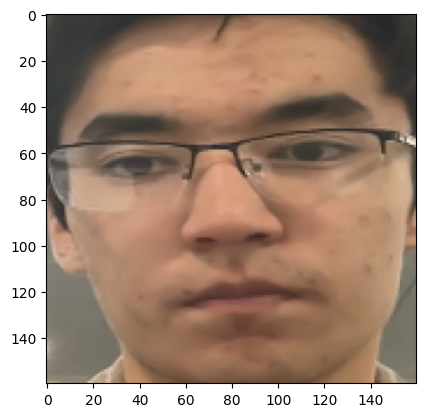

In [18]:
plt.imshow(img.numpy().astype('uint8'))

## Creating the database with image encodings

In [58]:
database = {}

In [59]:
for image in os.listdir("database (people)"):
    if image != ".DS_Store":
        person_name = image.split(".")[0]
        if person_name not in database:
            image_path = os.path.join("database (people)", image)
            database[person_name] = img_to_encoding(image_path, model)

1/1 [==============================] - 0s 332ms/step


In [72]:
database

{'resul': array([[ 6.13292046e-02, -3.96102145e-02,  1.89986471e-02,
          1.06927291e-01, -2.51848847e-02,  7.77995288e-02,
          1.66763917e-01, -6.45326599e-02, -1.28290877e-01,
          1.34984478e-01, -1.43712968e-01,  1.04645323e-02,
         -1.13617077e-01, -6.66637495e-02, -1.45471916e-01,
          6.19990937e-02,  7.89229572e-02,  2.07972080e-02,
          3.40920947e-02, -3.76380347e-02,  7.88322315e-02,
         -3.58174518e-02, -1.08130783e-01, -1.58417523e-01,
         -4.76896726e-02,  1.06757833e-02, -8.63152295e-02,
         -1.62862949e-02, -1.40183181e-01,  1.02801733e-01,
          1.34448305e-01, -7.86979198e-02, -6.30349740e-02,
         -1.36333890e-02,  7.35241175e-02, -7.21619949e-02,
         -8.23823586e-02, -3.00194938e-02,  9.60374922e-02,
          6.80349544e-02, -1.04157425e-01,  9.26801041e-02,
         -6.52665878e-03,  5.14688306e-02,  1.51520789e-01,
         -8.50672573e-02,  7.30409054e-03,  3.37608159e-01,
         -9.31796730e-02,  1.12

### Verify function: calculating the distance between the database encoding and image encoding

In [32]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
        image_path -- path to an image
        identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
        database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
        model -- your Inception model instance in Keras
    
    Returns:
        dist -- distance between the image_path and the image of "identity" in the database.
        door_open -- True, if the door should open. False otherwise.
    """
    ### START CODE HERE
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding = img_to_encoding(image_path, model)
    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(encoding - database[identity])
    # Step 3: Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True 
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
    ### END CODE HERE        
    return dist, door_open

In [91]:
image_path = os.path.join("custom_images", "almaz_alikhan.jpg")

In [92]:
verify(image_path, "nurdaulet_nazarbay", database, model)

1/1 [==============================] - 0s 156ms/step
It's not nurdaulet_nazarbay, please go away


(1.0753896, False)

## face verification real time test

In [33]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)

while cap.isOpened( ):
    ret, frame = cap.read()
    
    frame = cv2.flip(frame, 1)
    
    # Collect anchors
    if cv2.waitKey(100) & 0xFF == ord('v'):
        # Save input image toface_verification_input_image folder
        
        image_path = os.path.join('input_image.jpg')
        cv2.imwrite(image_path, frame)
        

        # Run verification
        dist, verified = verify(image_path, "bekarys_omirzakov", database, model)
        print(verified, dist)
        
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefulLy
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break

        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()
cv2.waitKey(1)

1/1 [==============================] - 0s 148ms/step
It's not bekarys_omirzakov, please go away
False 1.0812101
1/1 [==============================] - 0s 222ms/step
It's not bekarys_omirzakov, please go away
False 1.1589066
1/1 [==============================] - 0s 217ms/step
It's not bekarys_omirzakov, please go away
False 1.1071225
1/1 [==============================] - 0s 211ms/step
It's bekarys_omirzakov, welcome in!
True 0.5847914
1/1 [==============================] - 0s 184ms/step
It's bekarys_omirzakov, welcome in!
True 0.6213611
1/1 [==============================] - 0s 187ms/step
It's bekarys_omirzakov, welcome in!
True 0.67117697


-1

## face recognition real time test

In [38]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- your Inception model instance in Keras
    
    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
    """
    
    ### START CODE HERE

    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding = img_to_encoding(image_path, model)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        dist = np.linalg.norm(encoding - db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name
    ### END CODE HERE
    
    if min_dist > 0.7:
        print("Not in the database. " + str(min_dist))
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

In [41]:
image_path = os.path.join('face_verification_input_image', 'input_image.jpg')

In [42]:
who_is_it(image_path, database, model)

1/1 [==============================] - 0s 222ms/step
Not in the database. 0.8326011


(0.8326011, 'nurdaulet_nazarbay')

In [60]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)

while cap.isOpened( ):
    ret, frame = cap.read()
    
    frame = cv2.flip(frame, 1)
    
    # Collect anchors
    if cv2.waitKey(100) & 0xFF == ord('v'):
        # Save input image toface_verification_input_image folder
        
        image_path = os.path.join('face_verification_input_image', 'input_image.jpg')
        cv2.imwrite(image_path, frame)
        

        # Run verification
        dist, person = who_is_it(image_path, database, model)
        
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefulLy
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break

        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()
cv2.waitKey(1)

1/1 [==============================] - 0s 337ms/step
Not in the database. 0.8245163
1/1 [==============================] - 0s 332ms/step
it's merei_abaidildyn, the distance is 0.44754463
1/1 [==============================] - 0s 323ms/step
Not in the database. 0.7066971
1/1 [==============================] - 0s 335ms/step
Not in the database. 0.7661843


-1